In [1]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
import os
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
cluster = LocalCluster(n_workers=2, threads_per_worker=1, memory_limit='16GB')
client = Client(cluster)
print("Dask client dashboard link:", client.dashboard_link)

/home/lukap/.local/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42847 instead
  warnings.warn(


Dask client dashboard link: http://127.0.0.1:42847/status


2025-05-24 11:58:22,026 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 222986821f14db2350590f742cbdaeb5 initialized by task ('shuffle-transfer-222986821f14db2350590f742cbdaeb5', 37) executed on worker tcp://127.0.0.1:33931
2025-05-24 11:59:11,861 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 222986821f14db2350590f742cbdaeb5 deactivated due to stimulus 'task-finished-1748080751.8607275'
2025-05-24 11:59:37,228 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1576da989a24f6fb3e1725aaa921765b initialized by task ('shuffle-transfer-1576da989a24f6fb3e1725aaa921765b', 30) executed on worker tcp://127.0.0.1:33931
2025-05-24 11:59:40,580 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1576da989a24f6fb3e1725aaa921765b deactivated due to stimulus 'task-finished-1748080780.5796406'
2025-05-24 11:59:43,723 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9620a5c4da3a046b5a76fd40f808c649 initialized by task ('shuffle-transfer-9620a5c4da3a

In [10]:
def fetch_yellow_taxi_data(columns):
    file_path = "data/trip_record_data/yellow_taxi/*.parquet"
    columns = columns if "tpep_pickup_datetime" in columns else columns.append("tpep_pickup_datetime")

    ddf = dd.read_parquet(
        file_path,
        columns=columns,
        engine='pyarrow'
    )

    ddf['Year'] = ddf["tpep_pickup_datetime"].dt.year.astype('int32')
    ddf = ddf[(ddf['Year'] >= 2012) & (ddf['Year'] <= 2024)]

    return ddf

def fetch_green_taxi_data(columns):
    file_path = "data/trip_record_data/green_taxi/*.parquet"
    columns = columns if "lpep_pickup_datetime" in columns else columns.append("lpep_pickup_datetime")

    ddf = dd.read_parquet(
        file_path,
        columns=columns,
        engine='pyarrow'
    )

    ddf['Year'] = ddf["lpep_pickup_datetime"].dt.year.astype('int32')
    ddf = ddf[(ddf['Year'] >= 2012) & (ddf['Year'] <= 2024)]

    return ddf

def fetch_for_hire_data(columns):
    file_path = "data/trip_record_data/for_hire/*.parquet"
    columns = columns if "pickup_datetime" in columns else columns.append("pickup_datetime")

    ddf = dd.read_parquet(
        file_path,
        columns=columns,
        engine='pyarrow'
    )

    ddf['Year'] = ddf["pickup_datetime"].dt.year.astype('int32')
    ddf = ddf[(ddf['Year'] >= 2012) & (ddf['Year'] <= 2024)]

    return ddf

def fetch_High_volume_data(columns):
    file_path = "data/trip_record_data/high_volume/*.parquet"
    columns = columns if "pickup_datetime" in columns else columns.append("pickup_datetime")

    ddf = dd.read_parquet(
        file_path,
        columns=columns,
        engine='pyarrow'
    )

    ddf['Year'] = ddf["pickup_datetime"].dt.year.astype('int32')
    ddf = ddf[(ddf['Year'] >= 2012) & (ddf['Year'] <= 2024)]

    return ddf

def save_latex_and_svg(df, path):
    os.makedirs(path, exist_ok = True)
    figure_path = os.path.join(path, "figure.svg")
    latex_path = os.path.join(path, "table.tex")

    plt.figure(figsize=(5, 5))
    plt.bar(df["Year"], df["Normalized Problematic Rows Count"])
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout()
    plt.savefig(figure_path)

    df.to_latex(latex_path, index = False)


2025-05-24 11:58:45,109 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.32 GiB -- Worker memory limit: 7.45 GiB
2025-05-24 11:59:07,512 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.28 GiB -- Worker memory limit: 7.45 GiB
2025-05-24 11:59:23,208 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

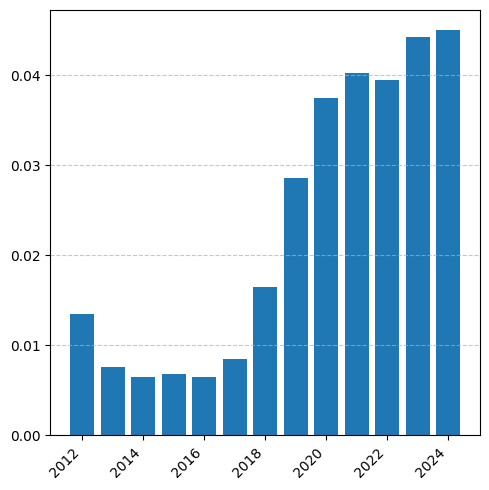

In [4]:
ddf = fetch_yellow_taxi_data(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'passenger_count', 'fare_amount'])

case1 = ddf['tpep_pickup_datetime'] == ddf['tpep_dropoff_datetime']
case2 = ddf['tpep_pickup_datetime'] > ddf['tpep_dropoff_datetime']
case3 = ddf["trip_distance"] <= 0
case4 = ddf["trip_distance"] > 100
case5 = ddf["passenger_count"] == 0
case6 = ddf["fare_amount"] <= 0
case7 = ddf["fare_amount"] > 350

problematic_rows = ddf[case1 | case2 | case3 | case4 | case5 | case6 | case7]
yearly_problems_counts = problematic_rows.groupby('Year').size().to_frame(name='Problematic Row Count')
result_table = yearly_problems_counts.compute().reset_index().sort_values(by = ["Year"])

total_rows_per_year = ddf.groupby('Year').size().to_frame(name='Total Row Count').compute().reset_index()

normalized_results = pd.merge(result_table, total_rows_per_year, on='Year', how='left')
normalized_results['Normalized Problematic Rows Count'] = normalized_results['Problematic Row Count'] / normalized_results['Total Row Count']

save_latex_and_svg(normalized_results, "data/T2/yellow_taxi/")

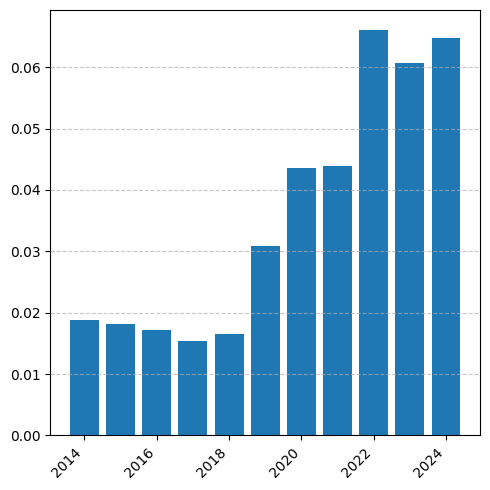

In [5]:
ddf = fetch_green_taxi_data(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'trip_distance', 'passenger_count', 'fare_amount'])

case1 = ddf['lpep_pickup_datetime'] == ddf['lpep_dropoff_datetime']
case2 = ddf['lpep_pickup_datetime'] > ddf['lpep_dropoff_datetime']
case3 = ddf["trip_distance"] <= 0
case4 = ddf["trip_distance"] > 100
case5 = ddf["passenger_count"] == 0
case6 = ddf["fare_amount"] <= 0
case7 = ddf["fare_amount"] > 350

problematic_rows = ddf[case1 | case2 | case3 | case4 | case5 | case6 | case7]
yearly_problems_counts = problematic_rows.groupby('Year').size().to_frame(name='Problematic Row Count')
result_table = yearly_problems_counts.compute().reset_index().sort_values(by = ["Year"])

total_rows_per_year = ddf.groupby('Year').size().to_frame(name='Total Row Count').compute().reset_index()

normalized_results = pd.merge(result_table, total_rows_per_year, on='Year', how='left')
normalized_results['Normalized Problematic Rows Count'] = normalized_results['Problematic Row Count'] / normalized_results['Total Row Count']

save_latex_and_svg(normalized_results, "data/T2/green_taxi/")

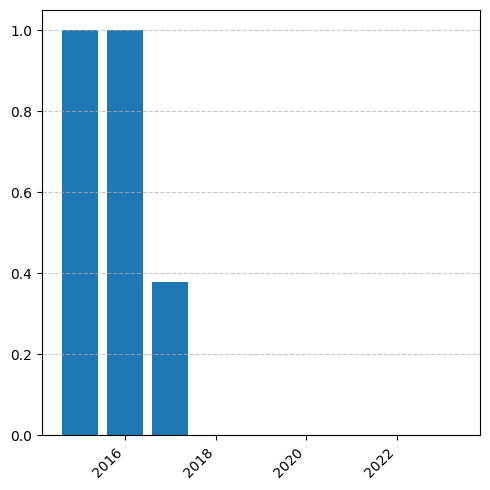

In [6]:
ddf = fetch_for_hire_data(['pickup_datetime', 'dropOff_datetime'])

case1 = ddf['pickup_datetime'] == ddf['dropOff_datetime']
case2 = ddf['pickup_datetime'] > ddf['dropOff_datetime']

problematic_rows = ddf[case1 | case2 ]
yearly_problems_counts = problematic_rows.groupby('Year').size().to_frame(name='Problematic Row Count')
result_table = yearly_problems_counts.compute().reset_index().sort_values(by = ["Year"])

total_rows_per_year = ddf.groupby('Year').size().to_frame(name='Total Row Count').compute().reset_index()

normalized_results = pd.merge(result_table, total_rows_per_year, on='Year', how='left')
normalized_results['Normalized Problematic Rows Count'] = normalized_results['Problematic Row Count'] / normalized_results['Total Row Count']

save_latex_and_svg(normalized_results, "data/T2/for_hire/")

In [ ]:
ddf = fetch_High_volume_data(['pickup_datetime', 'dropoff_datetime', 'trip_miles', 'base_passenger_fare', 'trip_time'])

case1 = ddf['pickup_datetime'] == ddf['dropoff_datetime']
case2 = ddf['pickup_datetime'] > ddf['dropoff_datetime']
case3 = ddf["trip_miles"] <= 0
case4 = ddf["trip_miles"] > 100
case5 = ddf["trip_time"] <= 0
case6 = ddf["base_passenger_fare"] <= 0
case7 = ddf["base_passenger_fare"] > 350

problematic_rows = ddf[case1 | case2 | case3 | case4 | case5 | case6 | case7]
yearly_problems_counts = problematic_rows.groupby('Year').size().to_frame(name='Problematic Row Count')
result_table = yearly_problems_counts.compute().reset_index().sort_values(by = ["Year"])

total_rows_per_year = ddf.groupby('Year').size().to_frame(name='Total Row Count').compute().reset_index()

normalized_results = pd.merge(result_table, total_rows_per_year, on='Year', how='left')
normalized_results['Normalized Problematic Rows Count'] = normalized_results['Problematic Row Count'] / normalized_results['Total Row Count']

save_latex_and_svg(normalized_results, "data/T2/green_taxi/")

2025-05-24 12:06:30,508 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.22 GiB -- Worker memory limit: 7.45 GiB
2025-05-24 12:06:33,708 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.22 GiB -- Worker memory limit: 7.45 GiB
2025-05-24 12:06:40,704 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.00 GiB -- Worker memory limit: 7.45 GiB
2025-05-24 12:06:44,428 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

In [7]:
import duckdb

In [8]:
duckdb.sql("select * from 'data/trip_record_data/high_volume/*.parquet'").columns

['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag']

In [9]:
duckdb.sql("select pickup_datetime, PULocationID, DOLocationID from 'data/trip_record_data/high_volume/*.parquet' where year(pickup_datetime) = 2020 order by pickup_datetime desc")

┌─────────────────────┬──────────────┬──────────────┐
│   pickup_datetime   │ PULocationID │ DOLocationID │
│      timestamp      │    int64     │    int64     │
├─────────────────────┼──────────────┼──────────────┤
│ 2020-12-31 23:59:59 │          212 │           18 │
│ 2020-12-31 23:59:59 │          152 │           75 │
│ 2020-12-31 23:59:58 │          197 │           28 │
│ 2020-12-31 23:59:58 │          228 │          255 │
│ 2020-12-31 23:59:57 │          132 │          130 │
│ 2020-12-31 23:59:57 │          106 │          129 │
│ 2020-12-31 23:59:57 │           75 │          141 │
│ 2020-12-31 23:59:56 │          166 │          259 │
│ 2020-12-31 23:59:56 │           65 │          130 │
│ 2020-12-31 23:59:55 │           71 │          149 │
│          ·          │            · │            · │
│          ·          │            · │            · │
│          ·          │            · │            · │
│ 2020-12-31 23:28:30 │          183 │           58 │
│ 2020-12-31 23:28:30 │     